# 预训练语义分割模型预测-单张图像-Python API

推荐代码运行[云GPU环境](https://featurize.cn?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

同济子豪兄：https://space.bilibili.com/1900783

2022-1-11

## 进入 mmsegmentation 主目录

In [2]:
import os
os.chdir('mmsegmentation')

## 导入工具包

In [3]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import mmcv
from mmseg.apis import init_model, inference_model, show_result_pyplot
from mmseg.utils import register_all_modules
register_all_modules()

## Cityscapes数据集

Cityscapes语义分割数据集：https://www.cityscapes-dataset.com

[超详细！手把手带你轻松用 MMSegmentation 跑语义分割数据集](https://zhuanlan.zhihu.com/p/525422379)

19个类别
'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
'bicycle'

## 载入测试图像

In [4]:
from PIL import Image

# img_path = 'demo/demo.png'
img_path = 'data/street_uk.jpeg'

img_pil = Image.open(img_path)

In [5]:
img_pil.size

(2250, 1500)

In [6]:
# img_pil

## 载入模型

In [7]:
# 模型 config 配置文件
# config_file = 'configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py'
config_file = 'configs/mask2former/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024.py'

# 模型 checkpoint 权重文件
# checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
checkpoint_file = 'https://download.openmmlab.com/mmsegmentation/v0.5/mask2former/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024_20221202_141901-28ad20f1.pth'


In [8]:
from mmseg.apis import init_model
model = init_model(config_file, checkpoint_file, device='cuda:0')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/mask2former/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024_20221202_141901-28ad20f1.pth


## 运行语义分割预测

In [9]:
from mmseg.apis import inference_model
from mmengine.model.utils import revert_sync_batchnorm
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)

In [10]:
result = inference_model(model, img_path)

/environment/miniconda3/lib/python3.7/site-packages/mmdet/models/layers/positional_encoding.py:84: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/environment/miniconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## 分析语义分割预测结果

In [11]:
# result

In [12]:
result.keys()

['seg_logits', 'pred_sem_seg']

In [13]:
# 类别：0-18，共 19 个 类别
result.pred_sem_seg.data.shape

torch.Size([1, 1500, 2250])

In [14]:
np.unique(result.pred_sem_seg.data.cpu())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 15])

In [15]:
result.pred_sem_seg.data.shape

torch.Size([1, 1500, 2250])

In [16]:
result.pred_sem_seg.data

tensor([[[10, 10, 10,  ..., 10, 10, 10],
         [10, 10, 10,  ..., 10, 10, 10],
         [10, 10, 10,  ..., 10, 10, 10],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]]], device='cuda:0')

In [17]:
pred_mask = result.pred_sem_seg.data[0].detach().cpu().numpy()

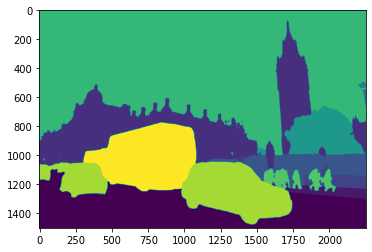

In [18]:
plt.imshow(pred_mask)
plt.show()

In [19]:
# 置信度
result.seg_logits.data.shape

torch.Size([19, 1500, 2250])

## 可视化语义分割预测结果-方法一

In [20]:
img_bgr = cv2.imread(img_path)

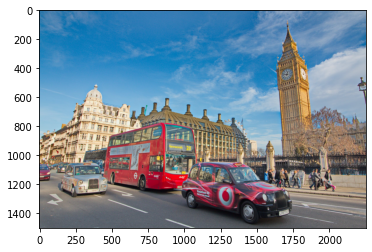

In [21]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

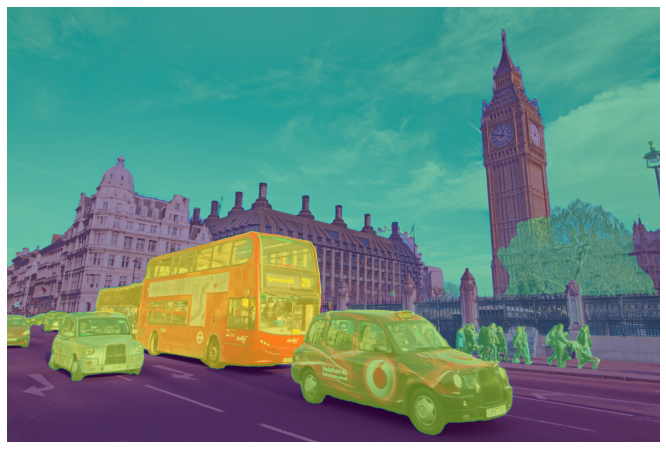

In [118]:
plt.figure(figsize=(14, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.imshow(pred_mask, alpha=0.55) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.savefig('outputs/B2-1.jpg')
plt.show()

## 可视化语义分割预测结果-方法二

In [120]:
alpha = 0.2
beta = 15
pred_mask_bgr = np.dstack((pred_mask, pred_mask, pred_mask)).astype('uint8')
img_viz = cv2.addWeighted(img_bgr, alpha, pred_mask_bgr, beta, 0)

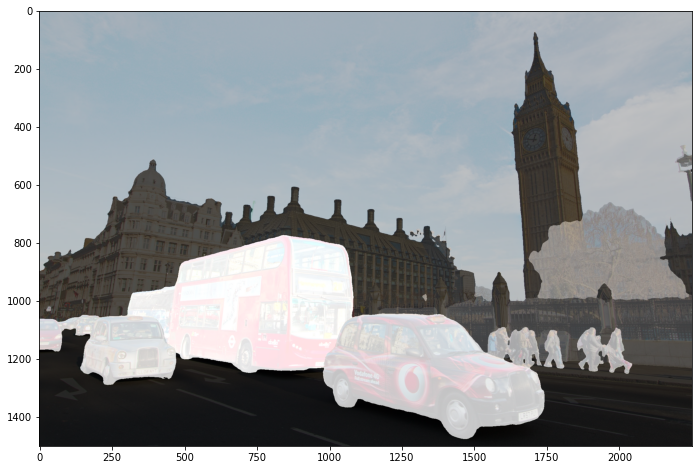

In [121]:
plt.figure(figsize=(14, 8))
plt.imshow(img_viz[:,:,::-1])
plt.show()

In [104]:
cv2.imwrite('outputs/B2-2.jpg', img_viz)

True

## 可视化语义分割预测结果-方法三

In [122]:
from mmseg.apis import show_result_pyplot

In [123]:
img_viz = show_result_pyplot(model, img_path, result, opacity=0.8, title='MMSeg', out_file='outputs/B2-3.jpg')

opacity控制透明度，越小，越接近原图。

In [124]:
img_viz.shape

(1500, 2250, 3)

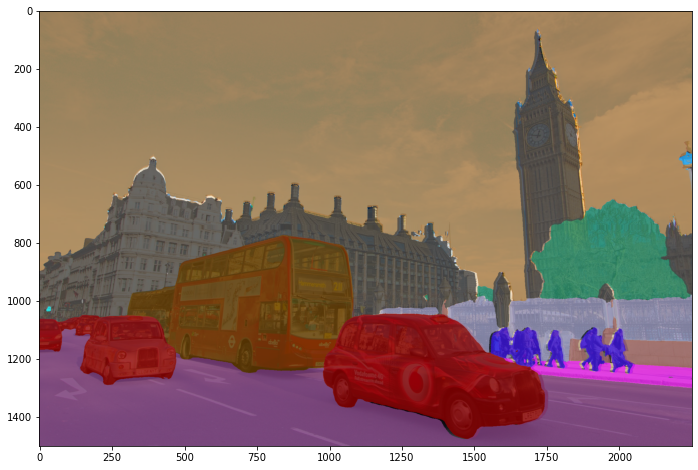

In [125]:
plt.figure(figsize=(14, 8))
plt.imshow(img_viz[:,:,::-1])
plt.show()

## 可视化语义分割预测结果-方法四

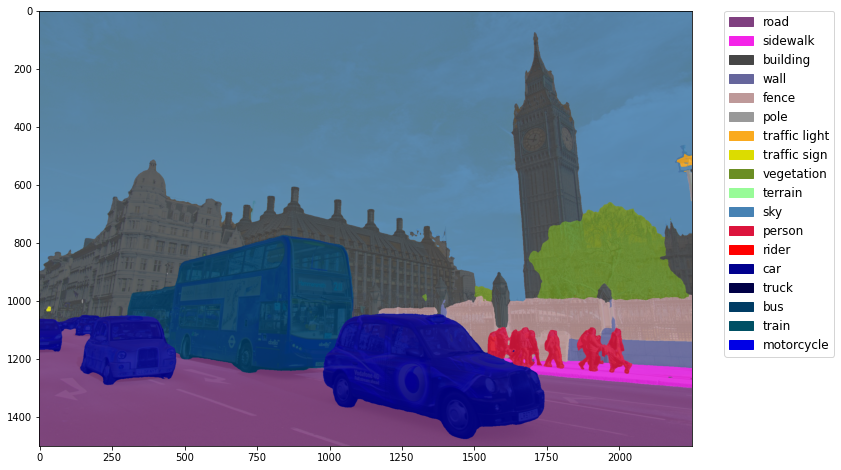

In [ ]:
import numpy as np
import mmcv 

# 获取类别名和调色板
classes = cityscapes.CityscapesDataset.METAINFO['classes']
palette = cityscapes.CityscapesDataset.METAINFO['palette']
opacity = 0.15 # 透明度，越大越接近原图

# 将分割图按调色板染色
# seg_map = result[0].astype('uint8')
seg_map = pred_mask.astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(14, 8))
im = plt.imshow(((np.array(seg_img.convert('RGB')))*(1-opacity) + mmcv.imread(img_path)*opacity) / 255)

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(len(classes))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.savefig('outputs/B2-4.jpg')
plt.show()